# Causal Story of E-Commerce Churn out

For sustainable growth the primary focus in E-Commerce business is increasing the **Customer Acquisition** and **Customer Retention**. To achieve that it should have low **Churn out Rate**. Fundamentally, **churn** occurs when a customer stops consuming from a company. A high churn rate equals a low retention rate. Churn affects the size of your customer base and has a big impact on your customer lifetime value.

We have considered what factors affect the customers to churn out using the E-Commerce Dataset publically available on <a href="https://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction">Kaggle</a>. 

## Importing libraries

In [1]:
import pygraphviz
import numpy as np 
import pandas as pd 
import dowhy
import matplotlib.pyplot as plt
import warnings

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'INFO',
        },
    }
}
logging.config.dictConfig(DEFAULT_LOGGING)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
from IPython.display import Image, display

## Data

In [2]:
data = pd.read_csv("EComm.csv")

In [3]:
data.columns

Index(['CustomerID', 'Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

In [4]:
data.isnull().sum()

CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

## Data Cleaning & Feature Engineering

We create a new variable **"SatisfactionFlag"** by grouping SatisfactionScore = 1 as **"HighlyDissatisfied"** and **"SatisfactionScore"** in categories 2-5 as 0

In [5]:
data['HighlyDissatisfied'] = data.apply(lambda x: True if(x['SatisfactionScore']<=1) else False, axis = 1)

In [6]:
data.drop(['CustomerID','SatisfactionScore'], axis = 1, inplace = True)
data.dropna(inplace = True)
data.reset_index().drop(['index'], axis = 1)

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,HighlyDissatisfied
0,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,Single,9,1,11.0,1.0,1.0,5.0,160,False
1,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,Single,8,0,23.0,0.0,1.0,3.0,134,False
2,1,0.0,Computer,1,22.0,Debit Card,Female,3.0,5,Mobile Phone,Single,2,1,22.0,4.0,6.0,7.0,139,False
3,1,11.0,Mobile Phone,1,6.0,Debit Card,Male,3.0,4,Fashion,Single,10,1,13.0,0.0,1.0,0.0,154,False
4,1,0.0,Phone,1,11.0,COD,Male,2.0,3,Mobile,Single,2,1,13.0,2.0,2.0,2.0,134,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3769,0,1.0,Mobile Phone,3,12.0,UPI,Female,2.0,5,Mobile Phone,Single,2,0,19.0,2.0,2.0,1.0,155,False
3770,0,10.0,Computer,1,30.0,Credit Card,Male,3.0,2,Laptop & Accessory,Married,6,0,18.0,1.0,2.0,4.0,151,True
3771,0,1.0,Mobile Phone,1,11.0,Debit Card,Male,3.0,2,Laptop & Accessory,Married,3,1,21.0,1.0,2.0,4.0,186,False
3772,0,23.0,Computer,3,9.0,Credit Card,Male,4.0,5,Laptop & Accessory,Married,4,0,15.0,2.0,2.0,9.0,179,False


## Creating DAG

In [7]:
causal_graph = """digraph {
HighlyDissatisfied[label="Highly Dissatisfied", color = "green",style="filled"];
Churn[label="Churning out", color = "red",style="filled"];
Complain[label="Complaint or not", color = "green",style="filled"];
DaySinceLastOrder[label="Days since Last order"];
CityTier[label="City Tier"];
OrderCount[label="Order Count"];
CouponUsed[label="Coupon Used"];
Tenure[label="Tenure with E Commerce"];
WarehouseToHome[label="Warehouse to Home Distance"];
CashBackAmount[label="Average Cashback in last month"];
OrderAmountHikeFromlastYear[label="Percentage increases in order from last year"];
PreferredLoginDevice[label="Preferred Login Device"];
HourSpendOnApp[label="Total Hours Spend on App"];
NumberOfAddress[label="Number of Addresses"];
NumberOfDeviceRegistered[label="Number of device registered"];
U[label="Unobserved Confounders",observed="no"];

U->{HighlyDissatisfied, CityTier, Tenure, CouponUsed, WarehouseToHome,PreferredLoginDevice};
HighlyDissatisfied -> Churn;
Complain -> {Churn, HighlyDissatisfied};
DaySinceLastOrder -> {Churn,OrderCount};
CityTier -> OrderCount;
CouponUsed -> {OrderCount,OrderAmountHikeFromlastYear};
OrderCount -> OrderAmountHikeFromlastYear;
OrderAmountHikeFromlastYear -> Churn;
Tenure -> OrderAmountHikeFromlastYear;
WarehouseToHome -> CityTier;
CashBackAmount -> OrderCount;
PreferredLoginDevice -> HourSpendOnApp;
HourSpendOnApp -> OrderCount;
NumberOfAddress -> NumberOfDeviceRegistered;
NumberOfDeviceRegistered -> OrderCount;
}"""

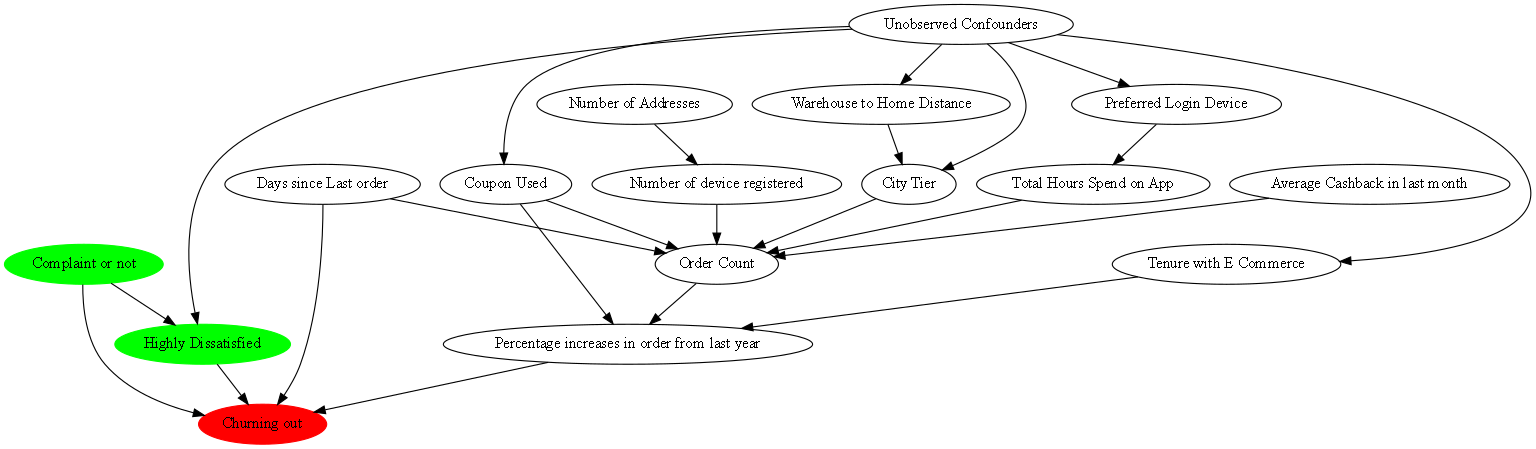

In [8]:
model= dowhy.CausalModel(
        data = data,
        graph=causal_graph.replace("\n", " "),
        treatment=["HighlyDissatisfied","Complain"],
        outcome='Churn')
model.view_model(size = (16,14))
display(Image(filename="causal_model.png",  width=1200, height=1200))

## Identify the Causal Effect

In [9]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
               d                                                              
───────────────────────────────(Expectation(Churn|DaySinceLastOrder,OrderAmoun
d[HighlyDissatisfied  Complain]                                               

                   
tHikeFromlastYear))
                   
Estimand assumption 1, Unconfoundedness: If U→{HighlyDissatisfied,Complain} and U→Churn then P(Churn|HighlyDissatisfied,Complain,DaySinceLastOrder,OrderAmountHikeFromlastYear,U) = P(Churn|HighlyDissatisfied,Complain,DaySinceLastOrder,OrderAmountHikeFromlastYear)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Estimate the identified estimand

In [10]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                       control_value=(0,0),
                                       treatment_value=(1,1),
                                       method_params={'need_conditional_estimates': False})
print(estimate)

linear_regression
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
               d                                                              
───────────────────────────────(Expectation(Churn|DaySinceLastOrder,OrderAmoun
d[HighlyDissatisfied  Complain]                                               

                   
tHikeFromlastYear))
                   
Estimand assumption 1, Unconfoundedness: If U→{HighlyDissatisfied,Complain} and U→Ch

The positive mean value indicate that “dissatisfaction + complaints” lead towards customer churn out.

## Refute results

### Method 1: Random Cause

In [11]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'eval

{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'eval

{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'eval

{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'eval

{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'eval

{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'eval

### Method 2: Data Subset Refueter

In [12]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'eval

{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'eval

{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'eval

{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'eval

{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'eval

{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['OrderCount', 'PreferredLoginDevice', 'WarehouseToHome', 'NumberOfAddress', 'DaySinceLastOrder', 'CouponUsed', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CashBackAmount', 'Tenure', 'CityTier', 'NumberOfDeviceRegistered'], 'need_conditional_estimates': False}
{'control_value': (0, 0), 'treatment_value': (1, 1), 'test_significance': False, 'eval